Install packages if required

In [3]:
# if not installed, install in local env
# !pip install --upgrade pip && \
#   pip install hrvanalysis && \
#     pip install plotly && \
#         pip install pyarrow && \
#             pip install fastparquet && \
#                 pip install seaborn && \
#                   pip install dask && \
#                       pip install pandas && \
#                         pip install scikit-learn && \
#                                 pip install sktime && \
#                                     pip install pmdarima

In [7]:
# general 
import pandas as pd 
import numpy as np 
import tensorflow as tf

# plotting
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)
pd.options.plotting.backend = "plotly"

# ML
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

from pmdarima.model_selection import train_test_split
from pmdarima import model_selection

# import common files
from common import timeseries_evaluation_metrics_func, WindowGenerator

import warnings
warnings.filterwarnings("ignore")

In [8]:
# load all dataframes
final_df = pd.read_parquet("Parquet Files/final_df.parquet.gzip")

In [9]:
# overwrite matplotlib figure size

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Naive mean:
- Forecast previous days using all values from previous day

In [10]:
y_df = final_df['glucose']
cv = model_selection.RollingForecastCV(h=24, step=24, initial=1098) # using pmdarima's rolling forecast
forecaster = NaiveForecaster(strategy="mean") # using sktime's naive forecaster

In [11]:
def rolling_validator(generator, y_data, model, X_data=None):
    """Walk forward forecasting using fixed train set and moving test set

    Args:
        generator (pmdarima forecaster object): Either rollingforecast or slidingforecast generators from pmdarima
        y_data (Iterable): Pandas series or numpy array of values to forecast
        model (Forecast Model): A model compatible with sci-kit learn's API of fit, predict
        X_data (Pandas Dataframe, optional): Optional exogenous data to use. Defaults to None.

    Returns:
        Tuple: A tuple of a list of predictions for each window, a list of rmse errors for each window, and mae errors
        for each window
    """
    
    # make generator
    cv_generator = generator.split(y=y_data, X=X_data)
    all_predictions, rmse_err, mae_err = [], [], []
    
    # loop through array, perform fit + predict
    for window in cv_generator:
        train_window = y_data.iloc[window[0]].asfreq('5T')
        test_window = y_data.iloc[window[1]].asfreq('5T')
        

        # perform forecast
        model.fit(train_window)
        y_pred = model.predict(
            fh=ForecastingHorizon(test_window.asfreq("5T").index,
                                          is_relative=False))        

        # # compute errors
        err = timeseries_evaluation_metrics_func(y_true=test_window.values,
                                                 y_pred=y_pred)
        
        # append values for plotting
        all_predictions.append(y_pred)
        rmse_err.append(err["rmse"])
        mae_err.append(err["mae"])
    
        
    return all_predictions, rmse_err, mae_err

i, j, k = rolling_validator(cv, final_df['glucose'], forecaster)

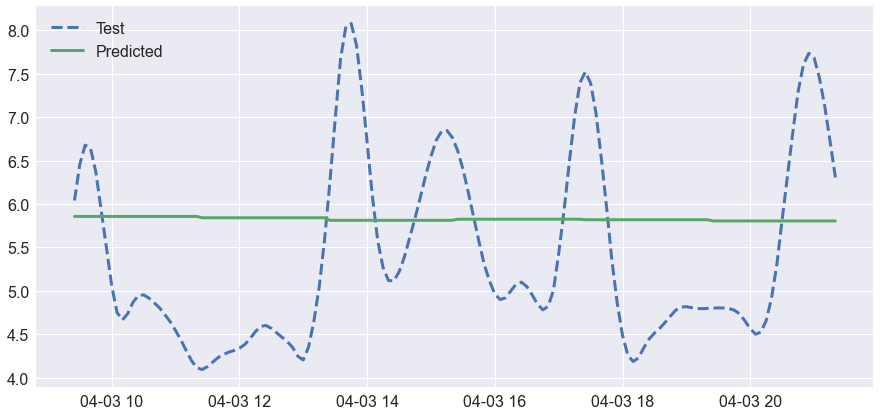

In [12]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(final_df['glucose'][1098:-13], label="Test", linewidth=3, linestyle='dashed')
ax.plot(pd.concat(i), label="Predicted", linewidth=3)
ax.legend(loc='best')
fig.show()

In [15]:
rmse = np.mean(j)
mae = np.mean(k)
print (f"RMSE is {rmse}, MAE is {mae}")

RMSE is 1.133150226452969, MAE is 1.043660464896398
